In [1]:
import pandas as pd
import numpy as np

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

![Architecture](../assets/gate_of_lstm.webp)

In [3]:
# Intialize value of C_{t-1}, h_{t-1}, and x_{t}
x_t = 1.0
c_prev = 0.0
h_prev = 0.0

# Define weights and biases (all scalar)
w_f, u_f, b_f = 0.5, 0.1, 0.0
w_i, u_i, b_i = 0.4, 0.1, 0.0
w_c, u_c, b_c = 0.3, 0.1, 0.0
w_o, u_o, b_o = 0.6, 0.1, 0.0

# Gate calculations
f_t = sigmoid(w_f * x_t + u_f * h_prev + b_f)
i_t = sigmoid(w_i * x_t + u_i * h_prev + b_i)
g_t = tanh(w_c * x_t + u_c * h_prev + b_c)
c_t = f_t * c_prev + i_t * g_t
o_t = sigmoid(w_o * x_t + u_o * h_prev + b_o)
h_t = tanh(c_t) * o_t

# Print intermediate results
print("f_t (forget gate):", round(f_t, 4))
print("i_t (input gate):", round(i_t, 4))
print("g_t (cell candidate):", round(g_t, 4))
print("c_t (cell state):", round(c_t, 4))
print("o_t (output gate):", round(o_t, 4))
print("h_t (hidden state):", round(h_t, 4))

f_t (forget gate): 0.6225
i_t (input gate): 0.5987
g_t (cell candidate): 0.2913
c_t (cell state): 0.1744
o_t (output gate): 0.6457
h_t (hidden state): 0.1115


In [4]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from A11M.rnn.lstm import LSTM
from A11M.scale.standard import StandardScaler

lstm = LSTM(input_size=1, hidden_size=2, output_size=1)

inputs = [np.array([[1.0]]), np.array([[0.5]]), np.array([[0.2]])]

# Forward pass
outputs = lstm.forward(inputs)

# Print hidden states
for i, h in enumerate(outputs):
    print(f"Time step {i}: {h}")

Time step 0: [[-0.01391547 -0.02415795]]
Time step 1: [[-0.01171572 -0.0245462 ]]
Time step 2: [[-0.00654368 -0.01762934]]


In [5]:
model = LSTM(input_size=1, hidden_size=4, output_size=1)

# Example sequence (predict alternation)
X = [np.array([[0.0]]), np.array([[1.0]]), np.array([[0.0]]), np.array([[1.0]])] * 100
Y = [np.array([[1.0]]), np.array([[0.0]]), np.array([[1.0]]), np.array([[0.0]])] * 100

for epoch in range(1000):
    loss = model.train_step(X[:10], Y[:10], lr=0.01)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

Epoch 0, Loss: 0.000112
Epoch 100, Loss: 0.000092
Epoch 200, Loss: 0.000075
Epoch 300, Loss: 0.000061
Epoch 400, Loss: 0.000050
Epoch 500, Loss: 0.000041
Epoch 600, Loss: 0.000033
Epoch 700, Loss: 0.000027
Epoch 800, Loss: 0.000022
Epoch 900, Loss: 0.000018


In [6]:
import kagglehub


path = kagglehub.dataset_download("umerhaddii/big-tech-giants-stock-price-data")

In [7]:
os.listdir(path)

['big_tech_companies.csv', 'big_tech_stock_prices.csv']

In [8]:
# read data big_tech_companies.csv
df_companies = pd.read_csv(os.path.join(path, 'big_tech_companies.csv'))
df_stock_prices = pd.read_csv(os.path.join(path, 'big_tech_stock_prices.csv'))

In [9]:
df_companies.head(n=5)

,stock_symbol,company
0,AAPL,Apple Inc.
1,ADBE,Adobe Inc.
2,AMZN,"Amazon.com, Inc."
3,CRM,"Salesforce, Inc."
4,CSCO,"Cisco Systems, Inc."


In [10]:
df_stock_prices.head()

,stock_symbol,date,open,high,low,close,adj_close,volume
0,AAPL,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,AAPL,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,AAPL,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
3,AAPL,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
4,AAPL,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800


In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [22]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [23]:
# Filter AAPL stock prices and sort by date
df = df_stock_prices[df_stock_prices['stock_symbol'] == 'AAPL'].copy()
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Use 'close' price as the target
prices = df['close'].values.astype(np.float32)

# Normalize prices (standard scaler)
mean = prices.mean()
std = prices.std()
prices_norm = (prices - mean) / std

# Create sequences: For example, use last 5 days to predict the next day price
def create_sequences(data, seq_length=5):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, Y = create_sequences(prices_norm, seq_length)

print("Shape X:", X.shape)  # (num_samples, seq_length)
print("Shape Y:", Y.shape)  # (num_samples,)

Shape X: (3266, 5)
Shape Y: (3266,)


In [24]:
class StockDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X).unsqueeze(-1)  # shape (N, seq_len, 1)
        self.Y = torch.tensor(Y).unsqueeze(-1)  # shape (N, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = StockDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [26]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [27]:
import torch.optim as optim

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

Epoch 0, Loss: 0.051930
Epoch 10, Loss: 0.001231
Epoch 20, Loss: 0.001160
Epoch 30, Loss: 0.001237
Epoch 40, Loss: 0.001366
Epoch 50, Loss: 0.001107
Epoch 60, Loss: 0.001416
Epoch 70, Loss: 0.001072
Epoch 80, Loss: 0.000999
Epoch 90, Loss: 0.001076


In [28]:
model.eval()
with torch.no_grad():
    test_seq = torch.tensor(prices_norm[-seq_length:]).unsqueeze(0).unsqueeze(-1)  # shape (1, seq_length, 1)
    pred_norm = model(test_seq).item()
    pred = pred_norm * std + mean
    actual = prices[-1]
    print(f"Predicted close: {pred:.2f}, Actual: {actual:.2f}")

Predicted close: 129.39, Actual: 129.61


In [30]:
test_data = prices_norm[-(100 + seq_length):]  # Need seq_length extra for sequences

def create_sequences(data, seq_length=5):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_test, Y_test = create_sequences(test_data, seq_length)

X_test_torch = torch.tensor(X_test).unsqueeze(-1)  # Shape (N_test, seq_length, 1)
Y_test_torch = torch.tensor(Y_test).unsqueeze(-1)  # Shape (N_test, 1)


In [31]:
model.eval()
with torch.no_grad():
    preds_norm = model(X_test_torch).squeeze().numpy() 

In [32]:
preds = preds_norm * std + mean
actuals = Y_test * std + mean

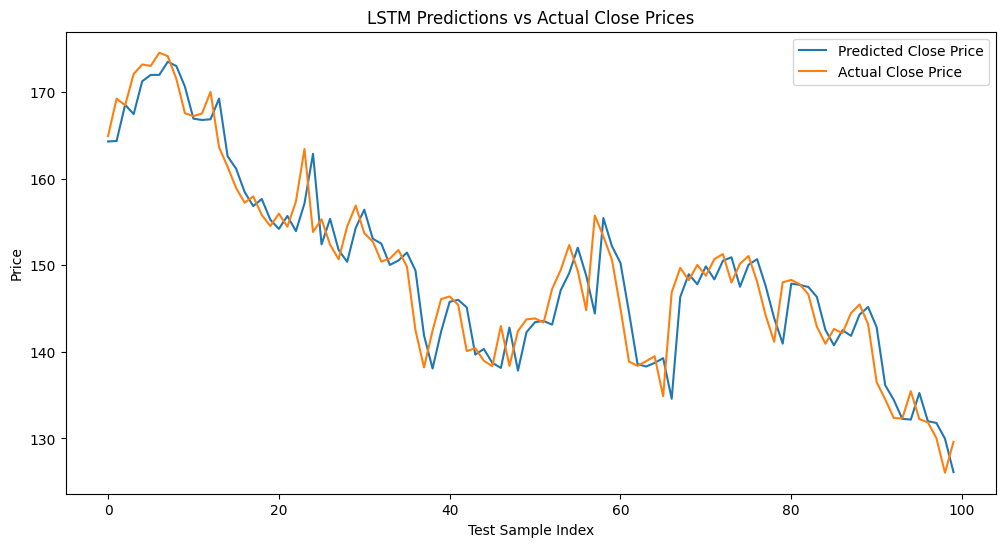

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(preds, label='Predicted Close Price')
plt.plot(actuals, label='Actual Close Price')
plt.title('LSTM Predictions vs Actual Close Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()